In [2]:
import numpy as np; np.random.seed(21)
import tensorflow as tf
keras = tf.keras
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings('ignore')

# Data Exploration

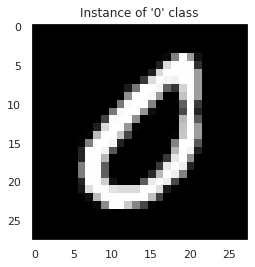

In [4]:
mnist = keras.datasets.mnist

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
assert X_train.shape[1:] == X_test.shape[1:], \
            f"Shapes mismatch: {X_train.shape} != {X_train.shape}"
X_train, X_test = X_train / 255., X_test / 255.

IMG_SIZE = (28, 28)

# Plot random digit
def plot_digit(digit, label):
    plt.figure()
    if digit.shape != IMG_SIZE:
        digit = digit.reshape(IMG_SIZE)
    plt.imshow(digit, cmap=mpl.cm.gray)
    plt.grid(False)
    plt.title(f"Instance of '{label}' class")
    

rnd_train_idx = np.random.randint(X_train.shape[0])
rnd_digit, rnd_class = X_train[rnd_train_idx], y_train[rnd_train_idx]

plot_digit(rnd_digit, rnd_class)

# Model Building

In [9]:
import functools


ReLU = functools.partial(keras.layers.Dense, activation='relu', kernel_initializer='he_normal')

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=IMG_SIZE),
    ReLU(300),
    ReLU(300),
    ReLU(100),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-4)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

SAVE_MODEL_FILEPATH = 'mnist__plain_relu_mlp__best.h5'

history = model.fit(X_train, y_train, epochs=50,
                    batch_size=32, validation_split=0.2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=10),
                        keras.callbacks.ModelCheckpoint(SAVE_MODEL_FILEPATH, save_best_only=True),
                    ])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 6s 122us/sample - loss: 0.2535 - accuracy: 0.9246 - val_loss: 0.1271 - val_accuracy: 0.9605
Epoch 2/50
48000/48000 [==============================] - 6s 122us/sample - loss: 0.1014 - accuracy: 0.9696 - val_loss: 0.0975 - val_accuracy: 0.9711
Epoch 3/50
48000/48000 [==============================] - 6s 115us/sample - loss: 0.0650 - accuracy: 0.9803 - val_loss: 0.0885 - val_accuracy: 0.9730
Epoch 4/50
48000/48000 [==============================] - 6s 116us/sample - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.0910 - val_accuracy: 0.9723
Epoch 5/50
48000/48000 [==============================] - 6s 120us/sample - loss: 0.0297 - accuracy: 0.9915 - val_loss: 0.0819 - val_accuracy: 0.9772
Epoch 6/50
48000/48000 [==============================] - 6s 132us/sample - loss: 0.0201 - accuracy: 0.9942 - val_loss: 0.0793 - val_accuracy: 0.9778
Epoch 7/50
48000/48000 [==========================

# Conclusion

In [10]:
best_model = keras.models.load_model(SAVE_MODEL_FILEPATH)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss}\nTest accuracy: {test_accuracy}")

Test loss: 0.06642677093962047
Test accuracy: 0.9812999963760376


A simple neural network was trained on MNIST dataset. This is an example of classification task, using supervised methods. During training the model was prevented from overfitting the training data using early stopping. The final model has the following architecture:

In [11]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_9 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 356,910
Trainable params: 356,910
Non-trainable params: 0
_________________________________________________________________


Although this network is fairly simple and relatively small (only `356910` trainable parameters), it was able to reach quickly global minimum (`test_loss=0.0664`) and demonstrate high performance (`test_accuracy=0.9813`), because it was trained using Nesterov Accelerated Gradient and Performance Scheduling techniques. Another factor for such quick convergence is that each layer's weights were initialized with He normal initialization (`mean=0, variance=2/fan_in`), which perfectly suits for using with the ReLU layers and helps alleviate the vanishing gradient problem.

Further performance improvements (considering use of optimization and regularization techniques only, and ignoring fancier DNN architectures) might be achieved through experimenting with activation functions, such as different variants of ReLU or ELU.